# 第 4 章：从头开始实现 GPT 模型以生成文本

本章节中中使用的软件包：

In [ ]:
from importlib.metadata import version

import matplotlib
import transformers
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("transformers version:", version("transformers"))

matplotlib version: 3.9.2
torch version: 2.5.1
transformers version: 4.46.3


- 在本章中，我们实现了类似 GPT 的 LLM 架构；下一章将重点介绍如何训练这个 LLM

## 4.1 编写 LLM 架构

- GPT 和 Llama 等模型，它们按顺序生成单词，并基于原始 Transformer 架构的解码器部分
- 因此，这些 LLM 通常被称为“类似解码器”的 LLM
- 与传统的深度学习模型相比，LLM 更大，主要是因为它们有大量的参数，而不是代码量
- 我们将看到 LLM 架构中有许多元素是重复的

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- 在前面的章节中，为了便于说明，我们使用了较小的嵌入维度作为 token 输入和输出，以确保它们适合一页纸
- 在本章中，我们将嵌入和模型大小视为类似于小型 GPT-2 模型
- 我们将专门编写最小 GPT-2 模型（1.24 亿个参数）的架构，如 Radford 等人的 [语言模型是无监督的多任务学习器](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 中所述（请注意，初始报告将其列为 1.17 亿个参数，但后来在模型权重存储库中进行了更正）
- 第 6 章将展示如何将预训练权重加载到我们的实现中，这将与 345、762 和 1542 百万个参数的模型大小兼容

- 1.24 亿个参数的 GPT-2 模型的配置细节包括：

In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- 我们使用短变量名以避免以后出现长代码行
- `vocab_size` 表示词汇量为 50,257 个单词，由第 2 章中讨论的 BPE 标记器支持
- `context_length` 表示模型的最大输入标记数，由第 2 章中介绍的位置嵌入启用
- `emb_dim` 是标记输入的嵌入大小，将每个输入标记转换为 768 维向量
- `n_heads` 是第 3 章中实现的多头注意机制中的注意头数量
- `n_layers` 是模型中的变压器块数量，我们将在接下来的章节中实现
- `drop_rate` 是第 3 章中讨论的 dropout 机制的强度； 0.1 表示在训练期间丢弃 10% 的隐藏单元以减轻过度拟合
- `qkv_bias` 决定多头注意力机制（来自第 3 章）中的 `Linear` 层在计算查询（Q）、键（K）和值（V）张量时是否应包含偏差向量；我们将禁用此选项，这是现代 LLM 中的标准做法；但是，我们稍后将在第 5 章中将 OpenAI 的预训练 GPT-2 权重加载到我们的重新实现中时重新讨论这一点

- 基于以上GPT架构图和配置，我们创建一个临时的GPT模型结构

In [10]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

- 我们使用这个GPT模型进行预测

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

batch = []

txt1 = "每一次努力都让你感动"
txt2 = "每天都会有一个让你为"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[ 101, 3680,  671, 3613, 1222, 1213, 6963, 6375,  872, 2697, 1220,  102],
        [ 101, 3680, 1921, 6963,  833, 3300,  671,  702, 6375,  872,  711,  102]])


In [13]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 12, 50257])
tensor([[[-0.4861, -1.7260, -0.9098,  ..., -1.6543,  1.0015, -0.1265],
         [-0.7426,  0.3170, -1.0356,  ...,  0.2683,  0.7810,  1.0328],
         [ 1.0270,  0.7011,  0.8656,  ...,  0.6809,  0.9820,  0.5027],
         ...,
         [ 0.3738, -0.5697,  0.1975,  ...,  0.0135,  0.9371, -0.3787],
         [-0.0921,  0.7007,  0.1088,  ..., -0.2612,  2.0694, -0.4564],
         [-0.9083,  0.0310, -0.7223,  ..., -0.0951,  0.8682,  0.3021]],

        [[-0.4236, -1.7585, -0.5978,  ..., -1.1879,  0.9236, -0.1168],
         [-0.2728, -0.0083, -1.5874,  ...,  0.6486, -0.0817,  1.3792],
         [ 1.0387,  0.1747, -0.3449,  ...,  0.7163,  0.1071,  0.7383],
         ...,
         [ 0.6632, -1.6303,  0.6871,  ..., -0.3852,  0.9943,  1.5389],
         [ 0.6722,  0.4605,  0.1397,  ...,  0.3571, -0.5845,  0.9071],
         [-0.6749,  0.4457, -0.5928,  ..., -0.2233,  0.6367,  0.7214]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 使用层归一化来归一化激活

- 层归一化，也称为 LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450))，将神经网络层的激活集中在平均值 0 附近，并将其方差归一化为 1
- 这可以稳定训练并更快地收敛到有效权重
- 层归一化应用于 Transformer 块中的多头注意模块之前和之后，我们将在稍后实现；它也应用于最终输出层之前

- 减去平均值并除以方差（标准差）的平方根，使输入在列（特征）维度上具有平均值 0 和方差 1 的中心
- 使用 dim=-1 将在最后一个维度（在本例中为特征维度）而不是行维度上应用计算

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))  # 缩放
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # 移位

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**缩放和移位**

- 请注意，除了通过减去平均值并除以方差来执行标准化之外，我们还添加了两个可训练参数，即“缩放”和“移位”参数
- 初始“缩放”（乘以 1）和“移位”（添加 0）值没有任何影响；但是，“缩放”和“移位”是可训练参数，如果确定这样做会提高模型在训练任务上的性能，LLM 会在训练期间自动调整这些参数
- 这使得模型能够学习最适合其正在处理的数据的适当缩放和移位
- 请注意，在计算方差的平方根之前，我们还添加了一个较小的值（“eps”）；这是为了避免方差为 0 时出现除以零的错误

**有偏方差**
- 在上面方差计算中，设置 `unbiased=False` 意味着使用公式 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 计算方差，其中 n 是样本大小（此处为特征或列的数量）；此公式不包括贝塞尔校正（分母中使用 `n-1`），因此提供了方差的有偏估计
- 对于 LLM，嵌入维度 `n` 非常大，使用 n 和 `n-1` 之间的差异可以忽略不计
- 但是，GPT-2 在规范化层中使用有偏方差进行训练，这就是为什么我们也采用此设置以兼容我们将在后面章节中加载的预训练权重

In [18]:
batch_example = torch.randn(2, 5)
print("example:\n", batch_example)

ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

torch.set_printoptions(sci_mode=False) #禁用 PyTorch 的科学计数法：
print("Mean:\n", mean)
print("Variance:\n", var)

example:
 tensor([[ 0.4978, -1.8862, -0.4719,  0.4131,  1.0029],
        [-0.8605, -0.5995,  0.6999, -2.7565,  0.3921]])
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3 使用 GELU 激活实现前馈网络

- 在本节中，我们实现了一个小型神经网络子模块，该子模块用作 LLM 中 transformers 块的一部分
- 我们从激活函数开始
- 在深度学习中，ReLU（整流线性单元）激活函数因其在各种神经网络架构中的简单性和有效性而被广泛使用
- 在 LLM 中，除了传统的 ReLU 之外，还使用了各种其他类型的激活函数；两个值得注意的例子是 GELU（高斯误差线性单元）和 SwiGLU（Swish 门控线性单元）
- GELU 和 SwiGLU 是更复杂、更平滑的激活函数，分别包含高斯和 S 形门控线性单元，与更简单的分段线性函数 ReLU 不同，它们为深度学习模型提供了更好的性能

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) 可以通过多种方式实现；确切版本定义为 GELU(x)=x⋅Φ(x)，其中 Φ(x) 是标准高斯分布的累积分布函数。
- 在实践中，通常实现一种计算上更便宜的近似值：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$（原始 GPT-2 模型也使用此近似值进行训练）

In [19]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

- ReLU vs GELU

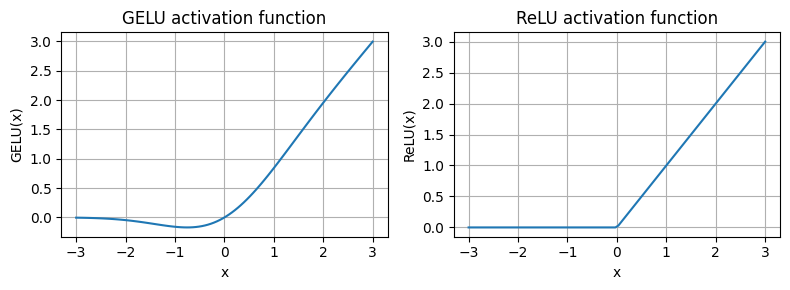

In [20]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 我们可以看到，ReLU 是一个分段线性函数，如果输入为正，则直接输出；否则，输出零
- GELU 是一个平滑的非线性函数，它近似于 ReLU，但对于负值（大约 -0.75 除外）具有非零梯度

- 接下来，让我们实现小型神经网络模块“FeedForward”，稍后我们将在 LLM 的转换器块中使用它：

In [21]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [22]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [23]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## 4.4 添加快捷连接

- 接下来，让我们谈谈快捷连接背后的概念，也称为跳过或残差连接
- 最初，快捷连接是在计算机视觉的深度网络（残差网络）中提出的，以缓解梯度消失问题
- 快捷连接为梯度在网络中流动创建了一条替代的较短路径
- 这是通过将一层的输出添加到后一层的输出来实现的，通常会跳过中间的一个或多个层
- 让我们用一个小的示例网络来说明这个想法：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- 在代码中，它看起来像这样：

In [24]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 让我们首先打印渐变值**不**快捷连接：

In [25]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- 接下来，让我们使用快捷连接打印渐变值：

In [26]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- 根据上面的输出，我们可以看到，快捷连接可以防止梯度在早期层（朝向“layer.0”）消失
- 接下来，当我们实现转换器块时，我们将使用快捷连接的概念

## 4.5 在 transformer 块中连接注意力层和线性层

- 在本节中，我们现在将前面的概念组合成所谓的 transformer 块
- transformer 块将上一章中的因果多头注意模块与线性层（我们在前面部分实现的前馈神经网络）相结合
- 此外，transformer 块还使用了 dropout 和快捷连接

In [27]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- 假设我们有 2 个输入样本，每个样本有 6 个 token，每个 token 是一个 768 维的嵌入向量；然后这个 Transformer 块应用自注意力，然后是线性层，以产生类似大小的输出
- 你可以将输出视为我们在上一章中讨论的上下文向量的增强版本

In [28]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 4.6 编写 GPT 模型

- 我们快完成了：现在让我们将 transformer 块插入到我们在本章一开始编码的架构中，以便获得可用的 GPT 架构
- 请注意，transformer 块重复多次；对于最小的 124M GPT-2 模型，我们重复 12 次：

- 相应的代码实现，其中`cfg["n_layers"] = 12`：

In [29]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用 124M 参数模型的配置，我们现在可以使用随机初始权重实例化此 GPT 模型，如下所示：

In [30]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 101, 3680,  671, 3613, 1222, 1213, 6963, 6375,  872, 2697, 1220,  102],
        [ 101, 3680, 1921, 6963,  833, 3300,  671,  702, 6375,  872,  711,  102]])

Output shape: torch.Size([2, 12, 50257])
tensor([[[-0.0910,  0.2955,  0.3264,  ...,  0.1190,  0.3435, -0.5948],
         [ 0.4672, -0.6172, -0.8405,  ..., -0.7265,  0.0654, -0.1599],
         [ 0.5158,  0.9571, -0.0230,  ...,  0.0084, -0.4536,  0.6241],
         ...,
         [-0.7312,  0.3959, -0.8328,  ..., -0.2122, -0.0894, -0.1170],
         [-0.1890,  0.0983, -0.7364,  ..., -0.0809, -0.6815,  0.1543],
         [-0.1267,  0.5618,  0.0703,  ...,  0.2241,  0.2546,  0.2940]],

        [[ 0.4087,  0.3463,  0.2460,  ..., -0.0992, -0.0571, -0.4619],
         [-0.1091,  0.0800, -0.5362,  ..., -0.5180,  0.1063, -0.1172],
         [ 1.1735,  0.7014,  0.2378,  ..., -0.4450, -0.0555,  0.0214],
         ...,
         [-0.8150,  0.4799,  0.5078,  ...,  0.5227,  0.7376, -0.2283],
         [-0.7882, -0.1511, -0.6471,  .

- 我们将在下一章中训练这个模型
- 但是，需要快速注意一下它的大小：我们之前将其称为 124M 参数模型；我们可以按如下方式再次检查这个数字：

In [31]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 如上所示，该模型有 163M 个参数，而不是 124M 个参数；为什么？
- 在原始 GPT-2 论文中，研究人员应用了权重绑定，这意味着他们重用了 token 嵌入层（`tok_emb`）作为输出层，这意味着设置 `self.out_head.weight = self.tok_emb.weight`
- token 嵌入层将 50,257 维独热编码输入 token 投影到 768 维嵌入表示
- 输出层将 768 维嵌入投影回 50,257 维表示，以便我们可以将它们转换回单词（下一节将详细介绍）
- 因此，嵌入层和输出层具有相同数量的权重参数，我们可以根据它们的权重矩阵的形状看到这一点
- 但是，关于它的大小有一个简要说明：我们之前将其称为 124M 参数模型；我们可以按如下方式再次检查这个数字：

In [32]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始 GPT-2 论文中，研究人员重新使用了 token embedding 矩阵作为输出矩阵
- 相应地，如果我们减去输出层的参数数量，我们将得到一个 124M 参数模型：

In [33]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 在实践中，我发现不使用权重绑定更容易训练模型，这就是我们没有在这里实现它的原因
- 但是，当我们在第 5 章中加载预训练权重时，我们将重新审视并应用这个权重绑定的想法
- 最后，我们可以按如下方式计算模型的内存需求，这可能是一个有用的参考点：

In [34]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 生成文本

- 我们上面实现的 GPT 模型之类的 LLM 每次用于生成一个单词

- 以下 `generate_text_simple` 函数实现贪婪解码，这是一种生成文本的简单快速方法
- 在贪婪解码中，在每个步骤中，模型都会选择概率最高的单词（或标记）作为其下一个输出（最高 logit 对应于最高概率，因此从技术上讲我们甚至不必明确计算 softmax 函数）
- 在下一章中，我们将实现更高级的 `generate_text` 函数
- 下图描述了 GPT 模型如何在给定输入上下文的情况下生成下一个单词标记

In [35]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 让我们准备一个输入示例：

In [39]:
start_context = "你好，我是"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [101, 872, 1962, 8024, 2769, 3221, 102]
encoded_tensor.shape: torch.Size([1, 7])


In [40]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[  101,   872,  1962,  8024,  2769,  3221,   102, 37256,  3798, 29021,
         19467,  7388, 15979]])
Output length: 13


- 删除批次维度并转换回文本：

In [42]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist(), skip_special_tokens=True)
print(decoded_text)

你 好 ， 我 是 泣诙 隍挹


- 请注意，该模型未经训练；因此上面的输出文本是随机的
- 我们将在下一章中训练该模型